# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

In [3]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

##### Напишем функцию для подсчета эффективности обогащения. На всякий случай избавимся от результатов меньше 0 и больше 100

In [4]:
def recovery(C, F, T):
    
    numerator = (C * (F - T))
    denominator = (F * (C - T))
    
    rec = numerator / denominator * 100
    
    rec[rec < 0] = np.nan
    rec[rec > 100] = np.nan
    return rec

In [5]:
c, f, t = df_train['rougher.output.concentrate_au'], df_train['rougher.input.feed_au'], df_train['rougher.output.tail_au']

In [6]:
rec = recovery(c, f, t)

In [7]:
df_train['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394201
std         15.096808
min          0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [8]:
rec.describe()

count    14287.000000
mean        82.394201
std         15.096808
min         -0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
dtype: float64

##### Как мы видим, с исходными данными совпало 14287 данных. Возможно, в остальных данных пропуски

In [9]:
rec = rec.fillna(method = 'ffill')

In [10]:
rec_true = df_train['rougher.output.recovery'].fillna(method = 'ffill')

In [11]:
mean_absolute_error(rec_true, rec)

9.514308413213554e-15

#####  Средняя абсолютная ошибка очень мала - данные посчитаны верно. Посмотрим, какие признаки есть в тренировочной выборке, но которых нет в тестовой

In [12]:
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

##### Признаки output - целевые, поэтому их нет. Так же отсутствуют признаки rougher.calculation, скорее всего это данные для дальнейших действий и пока недоступны

##### Посмотрим на пропуски в данных

In [13]:
def nulls(df):
    nulls = df.isna().sum()
    res = (pd.concat([nulls / df.shape[0], nulls], axis = 1,  keys = ['part', 'sum'])
           .sort_values('part', ascending = False))
    return res

In [14]:
nulls(df_train).head(10)

,part,sum
rougher.output.recovery,0.152610,2573
rougher.output.tail_ag,0.133452,2250
rougher.output.tail_sol,0.133393,2249
rougher.output.tail_au,0.133393,2249
secondary_cleaner.output.tail_sol,0.117794,1986
rougher.input.floatbank11_xanthate,0.112930,1904
final.output.recovery,0.090214,1521
primary_cleaner.input.sulfate,0.077521,1307
primary_cleaner.input.depressant,0.074852,1262
rougher.calculation.au_pb_ratio,0.073665,1242


In [15]:
nulls(df_test).head(10)

,part,sum
rougher.input.floatbank11_xanthate,0.060280,353
primary_cleaner.input.sulfate,0.051571,302
primary_cleaner.input.depressant,0.048497,284
rougher.input.floatbank10_sulfate,0.043887,257
primary_cleaner.input.xanthate,0.028347,166
rougher.input.floatbank10_xanthate,0.021004,123
rougher.input.feed_sol,0.011441,67
rougher.input.floatbank11_sulfate,0.009392,55
rougher.input.feed_rate,0.006831,40
secondary_cleaner.state.floatbank3_a_air,0.005806,34


##### Пропуски в тестовой выборке несущественны. В тренировочной серьезнее, но заполнять их пока не будем - посмотрим в дальнейшем, какой способ покажет себя лучше

##### Посмотрим как меняется концентрация металлов после первой и второй очистки

In [16]:
steps = ['rougher.input.feed',
        'rougher.output.concentrate',
        'primary_cleaner.output.concentrate',
        'final.output.concentrate']
metals = ['au', 'ag', 'pb']

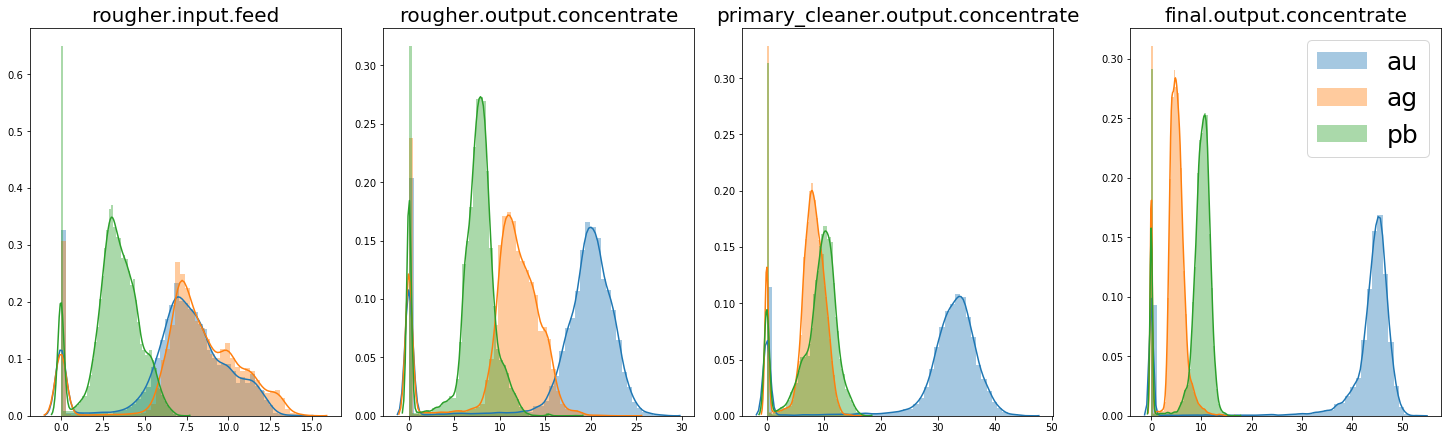

In [17]:
fig, axes = plt.subplots(1, 4, figsize = (20, 6), constrained_layout = True)

for step, ax in zip(steps, axes):
    ax.set_title(step, fontsize = 20)
    for metal in metals:        
        cols = df_train.columns.str.contains(step +'_'+ metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label = metal, ax = ax)    
plt.legend(prop = {'size': 25})
plt.show()

##### Концентрация золота сильно вырастает. Серебра и свинца тоже, но не так сильно

##### Рассмотрим размер гранул на обучающей и тестовой выборках

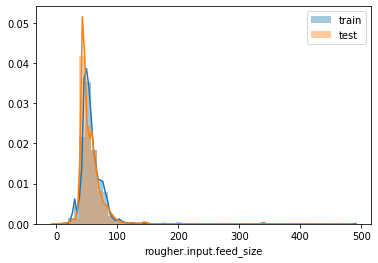

In [18]:
sns.distplot(df_train['rougher.input.feed_size'].dropna(), label = 'train');
sns.distplot(df_test['rougher.input.feed_size'].dropna(), label = 'test');
plt.legend();

##### В целом расспределения очень похожи

##### Рассмотрим суммарную концентрацию веществ на разных стадиях

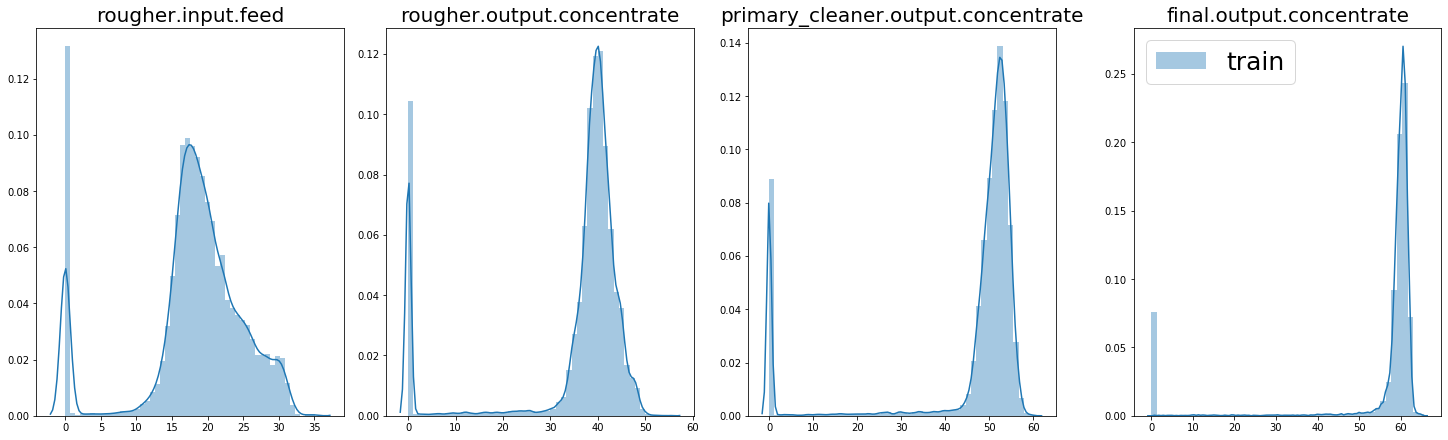

In [19]:
fig, axes = plt.subplots(1, 4, figsize = (20, 6), constrained_layout = True)

for step, ax in zip(steps, axes):
    ax.set_title(step, fontsize = 20)
    sum_train = df_train[step + '_ag'] + df_train[step + '_au'] + df_train[step + '_pb']
    sns.distplot(sum_train.dropna(), label = 'train', ax = ax) 

plt.legend(prop = {'size': 25})
plt.show()

##### Общая концентрация так же увеличилась

##### Перейдем к построению модели

In [20]:
def sMAPE(target, predictions, **kwargs):
    sum_rougher = 0
    sum_final = 0
    for i in range(target.shape[0]):
        sum_rougher += abs(target.loc[i, 'rougher.output.recovery'] - predictions.loc[i][0]) / ((abs(target.loc[i, 'rougher.output.recovery']) + abs(predictions.loc[i][0])) / 2)
        sum_final += abs(target.loc[i, 'final.output.recovery'] - predictions.loc[i][1]) / ((abs(target.loc[i, 'final.output.recovery']) + abs(predictions.loc[i][1])) / 2)
    return (0.25 * sum_rougher + 0.75 * sum_final) / len(target) * 100

##### Обучим несколько моделей и найдем лучший вариант с помощью кросс-валидаци

##### Модель случайного леса

In [21]:
df_train = df_train.fillna(method = 'ffill')

******************************************************

In [22]:
df_test['rougher.output.recovery'] = 0
df_test['final.output.recovery'] = 0

In [23]:
columns = set(df_train.columns) - set(df_test.columns)
df_train = df_train.drop(columns, 1)

******************************************************

In [24]:
train_features = df_train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
train_target = df_train[['rougher.output.recovery', 'final.output.recovery']]

In [25]:
features_train, features_valid, target_train, target_valid = train_test_split(train_features, train_target, test_size = 0.33, random_state = 12345)

In [26]:
target_valid2 = target_valid.reset_index(drop = True)

In [27]:
train_features.shape

(16860, 52)

In [28]:
df_test.shape

(5856, 55)

In [29]:
df_test = df_test.fillna(method = 'ffill')

In [30]:
df_train.shape

(16860, 55)

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
model_RFR = RandomForestRegressor()
model_LR = LinearRegression()
model_KNR = KNeighborsRegressor()

scores_RFR = cross_val_score(model_RFR, train_features, train_target)
scores_LR = cross_val_score(model_LR, train_features, train_target)
scores_KNR = cross_val_score(model_KNR, train_features, train_target)

score_RFR = scores_RFR.sum() / len(scores_RFR)
score_LR = scores_LR.sum() / len(scores_LR)
score_KNR = scores_KNR.sum() / len(scores_KNR)

print('model_RFR:', score_RFR)
print('model_LR:', score_LR)
print('model_KNR:', score_KNR)

model_RFR: -0.467767198540003
model_LR: -0.41722755863514666
model_KNR: -0.5172149313751806


##### Использовав кросс-валидацию на 3 моделях, лучшей себя показала модель линейной регрессии. Используем ее для подсчета sMAPE

In [33]:
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_valid)
predict = pd.DataFrame(predict)

************************

In [35]:
def smape(y_true, y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred.abs()) / 2
    result = (error / scale).mean()
    return result
 

def smape_weighted(y_true, y_pred):
    y_true.reset_index(drop=True, inplace=True)
    y_pred = pd.DataFrame(data=y_pred)
    rougher = smape(y_true.iloc[:, 0], y_pred.iloc[:, 0])
    final = smape(y_true.iloc[:, 1], y_pred.iloc[:, 1])
    return 0.25 * rougher + 0.75 * final


my_scorer =  make_scorer(smape_weighted, greater_is_better=False)

In [36]:
smape_RFR = cross_val_score(model_RFR, train_features, train_target, cv = 5 , scoring = my_scorer)

##### sMAPE для случайного леса

In [37]:
smape_RFR.mean()*100

-16.35298506703025

In [38]:
smape_LR = cross_val_score(model_LR, train_features, train_target, cv = 5, scoring = my_scorer)

##### sMAPE для линейной регрессии

In [39]:
smape_LR.mean() * 100

-16.96857327151733

In [40]:
smape_KNR = cross_val_score(model_KNR, train_features, train_target, cv = 5, scoring = my_scorer)

##### sMAPE для K ближайших соседей

In [41]:
smape_KNR.mean() * 100

-18.57101173773147

In [43]:
print(smape_weighted(train_target, [train_target.median()] * train_target.shape[0]))

0.14555160876538786


In [44]:
print(smape_weighted(train_target, predict))

0.15659866124604377


************************

In [45]:
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
target_test = df_test[['rougher.output.recovery', 'final.output.recovery']]

In [46]:
model_LR.fit(train_features, train_target)
test_predict = model_LR.predict(features_test)

In [47]:
df_new = df_full.loc[df_full['date'].isin(df_test['date'])]

In [48]:
print((smape_weighted(df_new[['rougher.output.recovery', 'final.output.recovery']], test_predict)))

0.10400894967297783


##### Итоговый sMAPE равен 10